In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df = pd.read_excel("data.xlsx")

In [3]:
df

,Customer_ID,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,CUS_0x1000,Alistair Barrf,17.375000,913-74-1218,Lawyer,30625.940,2706.161667,6.0,5.0,27,...,Bad,1562.91,33.477546,10.458333,Yes,42.941090,158.549735,High_spent_Medium_value_payments,335.375341,0
1,CUS_0x1009,Arunah,25.750000,063-67-6938,Mechanic,52312.680,4250.390000,6.0,5.0,17,...,Standard,202.68,29.839984,30.714286,Yes,108.366467,146.679378,High_spent_Medium_value_payments,428.743155,1
2,CUS_0x100b,Shirboni,18.500000,238-62-0395,Media_Manager,113781.390,9549.782500,1.0,4.0,1,...,Good,1030.20,34.841449,15.571429,No,0.000000,505.386526,High_spent_Large_value_payments,781.229776,0
3,CUS_0x1011,Schneyerh,43.875000,793-05-8223,Doctor,58918.470,5208.872500,3.0,3.0,17,...,Standard,473.14,27.655897,15.541667,Yes,123.434939,311.060914,Low_spent_Medium_value_payments,332.642837,1
4,CUS_0x1013,Cameront,43.750000,930-49-9615,Mechanic,98620.980,7962.415000,3.0,3.0,6,...,Good,1233.51,31.933940,17.535714,No,228.018084,355.442408,High_spent_Medium_value_payments,472.781009,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,CUS_0xff3,Somervilled,55.000000,726-35-5322,Scientist,17032.785,1176.398750,0.0,6.0,2,...,Good,1229.08,32.889398,17.000000,No,33.299764,83.918549,Low_spent_Small_value_payments,271.671562,1
12496,CUS_0xff4,Poornimaf,36.857143,655-05-7666,Entrepreneur,25546.260,2415.855000,8.0,7.0,14,...,Standard,758.44,32.598257,18.440476,Yes,101.328637,152.775690,Low_spent_Small_value_payments,259.981173,1
12497,CUS_0xff6,Shieldsb,18.625000,541-92-8371,Doctor,117639.920,9727.326667,5.0,6.0,1,...,Good,338.30,33.258053,24.625000,No,126.638453,655.228203,High_spent_Small_value_payments,667.322417,1
12498,CUS_0xffc,Brads,17.375000,226-86-7294,Musician,60877.170,5218.097500,6.0,8.0,27,...,Bad,1300.13,34.722108,12.861111,Yes,272.809169,156.172974,High_spent_Large_value_payments,339.951771,0


<Axes: >

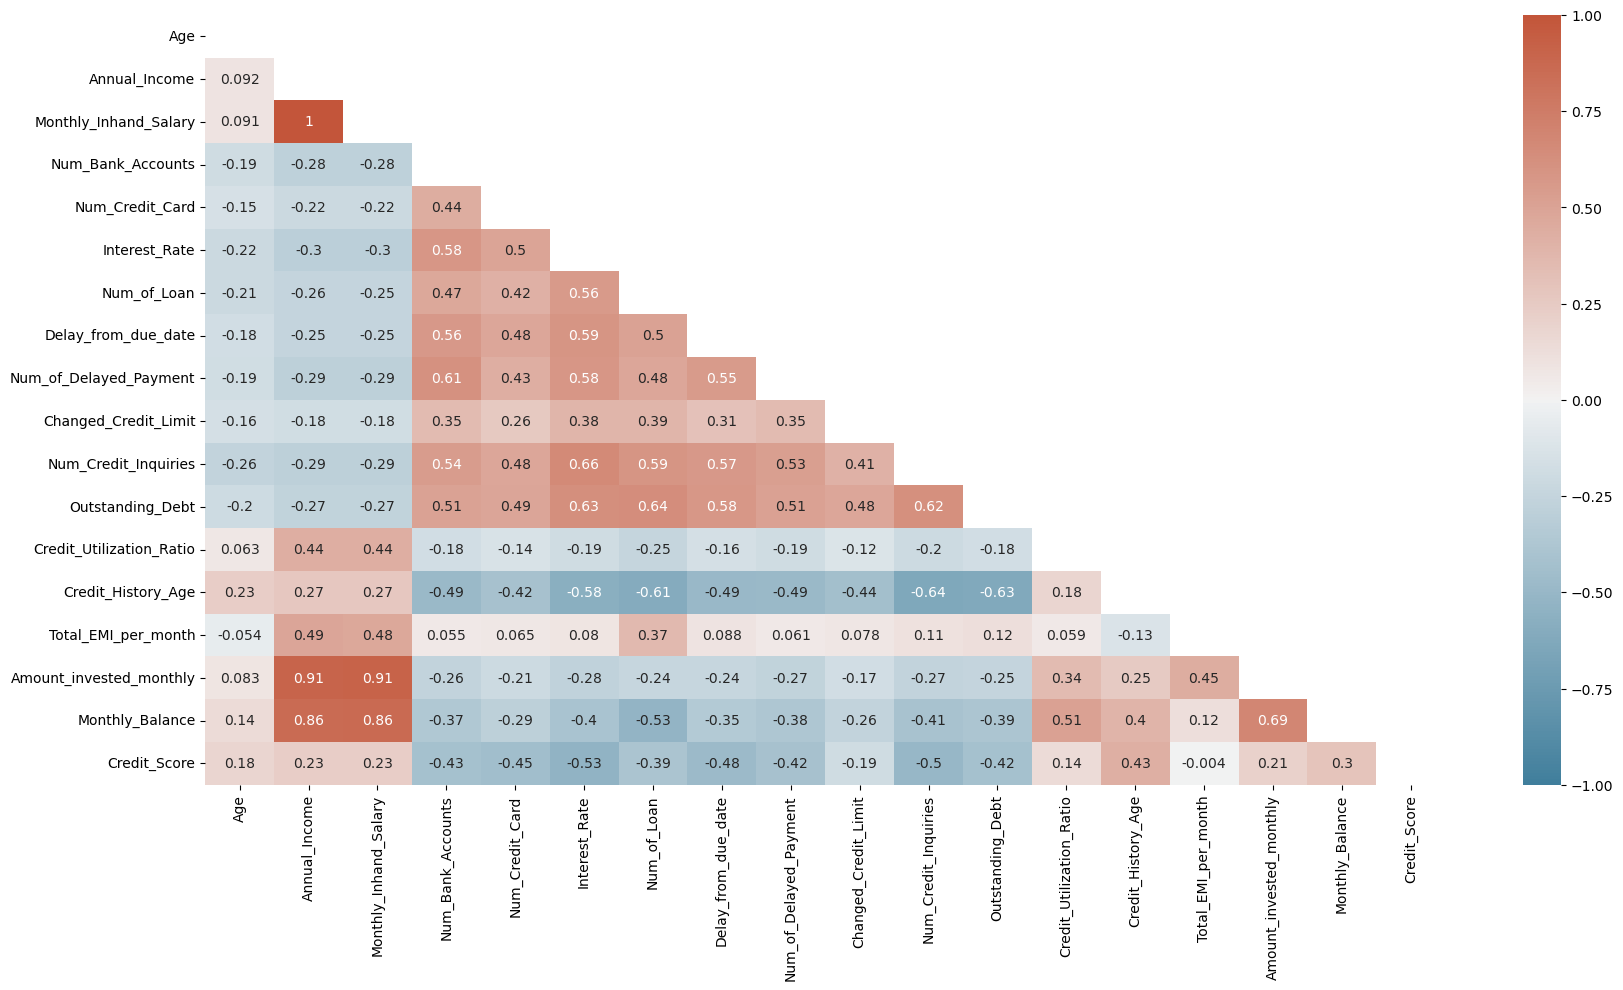

In [4]:
corr_matrix = df.corr(numeric_only=True)
for i in range(len(corr_matrix.index)):
    for j in range(i, len(corr_matrix.columns)):
        corr_matrix.loc[corr_matrix.index[i], corr_matrix.columns[j]] = np.nan
plt.figure(figsize=(20, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, cmap=cmap, vmin=-1, vmax=1, annot=True)

In [5]:
df_num = df.select_dtypes(include=['float64','int64'])

# Calculate VIF for each numerical column
vif = pd.DataFrame()
vif["Variance Inflation Factor, VIF"] = [variance_inflation_factor(df_num.values, i) for i in range(df_num.shape[1])]
vif["Features"] = df_num.columns

# Filter for high VIF columns
vif_high = vif[vif['Variance Inflation Factor, VIF']>10].sort_values(by='Variance Inflation Factor, VIF', ascending=False).reset_index(drop=True)

# Print the high VIF columns
print("Features with VIF > 10:")
print(vif_high)

Features with VIF > 10:
    Variance Inflation Factor, VIF                  Features
0                       926.781066             Annual_Income
1                       900.557010     Monthly_Inhand_Salary
2                        89.104974  Credit_Utilization_Ratio
3                        82.642812           Monthly_Balance
4                        26.561598   Amount_invested_monthly
5                        12.694102           Num_Credit_Card
6                        12.200196        Credit_History_Age
7                        11.223378    Num_of_Delayed_Payment
8                        11.181420                       Age
9                        10.582651         Num_Bank_Accounts
10                       10.388801               Num_of_Loan


In [6]:
def eliminate_high_vif(df, vif_threshold):

    # Calculate VIF for each numerical column
    vif = pd.DataFrame()
    vif["Variance Inflation Factor, VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif["features"] = df.columns

    if (vif["Variance Inflation Factor, VIF"]<vif_threshold).all():
        # All VIF scores are below the threshold
        return df.columns.tolist()
    
    # Drop the column with the highest VIF
    highest_vif_col = vif[vif["Variance Inflation Factor, VIF"]==vif["Variance Inflation Factor, VIF"].max()]["features"]
    df = df.drop(highest_vif_col, axis=1)
    
    # Recursively call the function to eliminate the highest-VIF feature until all VIF scores are below the threshold
    return eliminate_high_vif(df, vif_threshold)

In [7]:
# Eliminate highest-VIF feature recursively until all VIF scores are below the threshold
num_cols_vif_10 = eliminate_high_vif(df_num, 10)
df_num_new = df[num_cols_vif_10]

# Calculate VIF for each numerical column
vif_new = pd.DataFrame()
vif_new["Variance Inflation Factor, VIF"] = [variance_inflation_factor(df_num_new.values, i) for i in range(df_num_new.shape[1])]
vif_new["Features"] = df_num_new.columns

# Sort by VIF
vif_new = vif_new.sort_values(by='Variance Inflation Factor, VIF', ascending=False).reset_index(drop=True)

# Print the VIFs
print("Features with VIF <= 10")
print(vif_new)

Features with VIF <= 10
    Variance Inflation Factor, VIF                 Features
0                         9.174847                      Age
1                         9.099476        Num_Bank_Accounts
2                         9.015675            Interest_Rate
3                         7.843601     Num_Credit_Inquiries
4                         7.647597              Num_of_Loan
5                         7.635709       Credit_History_Age
6                         6.316065         Outstanding_Debt
7                         5.958586      Delay_from_due_date
8                         4.883511     Changed_Credit_Limit
9                         4.647763  Amount_invested_monthly
10                        3.503758             Credit_Score
11                        3.215560      Total_EMI_per_month


<Axes: >

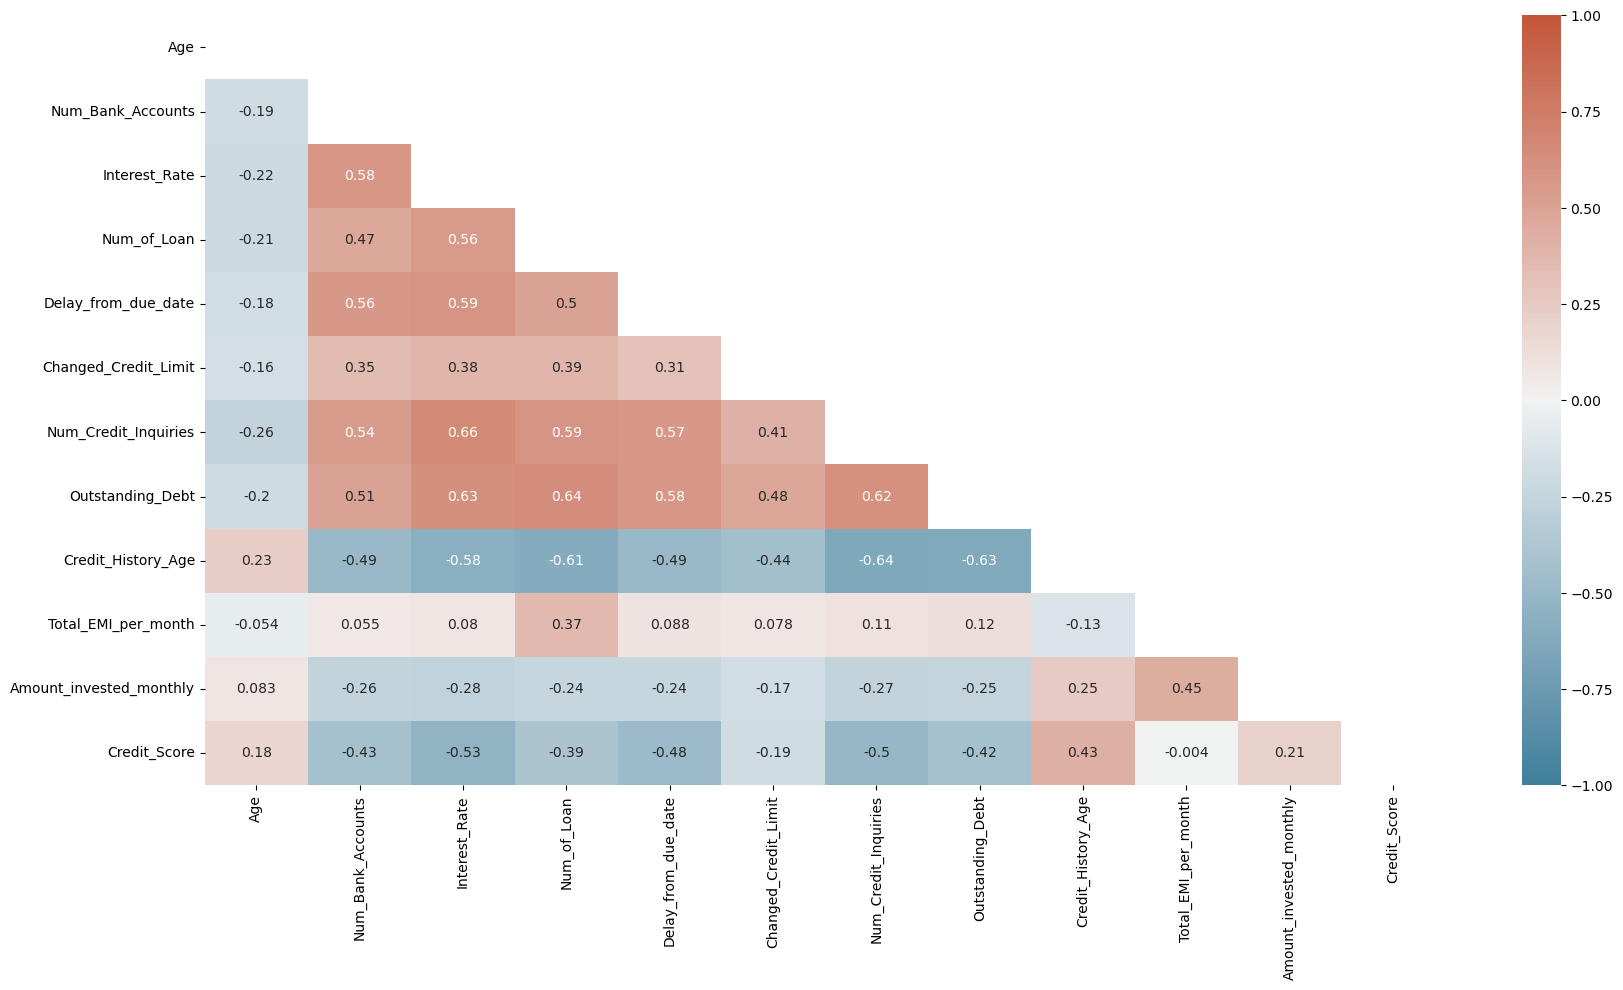

In [8]:
corr_matrix = df_num_new.corr(numeric_only=True)
for i in range(len(corr_matrix.index)):
    for j in range(i, len(corr_matrix.columns)):
        corr_matrix.loc[corr_matrix.index[i], corr_matrix.columns[j]] = np.nan
plt.figure(figsize=(20, 10))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, cmap=cmap, vmin=-1, vmax=1, annot=True)